# Aufgabe S&P 500 Classifier with PyTorch Lightning and VAE
27.11.2021, Thomas Iten

**Part I: Variational Autoencoder (VAE)**
1. SP500DataModule
2. Variational Autoencoder (VAE)
3. VAE Trainer
4. VAE Training
5. VAE Data Generation and Visualization

**Part II: SP500 Classification with extended data samples**
<ol start="6">
    <li>SP500VAEDataModule</li>
    <li>SP500ClassifierModel</li>
    <li>Train SP500ClassifierModel with extended data samples (SP500VAEDataModule)</li>
    <li>Test SP500ClassifierModel with original data (SP500DataModule)</li>
</ol>

**Part III: SP500 Classification with augmented model**
<ol start="10">
    <li>SP500VAEClassifierModel</li>
    <li>Train SP500VAEClassifierModel with original data (SP500DataModule)</li>
    <li>Test SP500VAEClassifierModel with original data (SP500DataModule)</li>
    <li>Visualize with Tensorboard</li>
</ol>

# Setup

In [1]:
# ! pip install yfinance

In [2]:
import os
import datetime
import time
import numpy as np
import pandas as pd
import bs4 as bs
import requests
import yfinance as yf

import torch
import torch.utils.data
import torch.utils.data as data_utils
from torch import nn, optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
from __future__ import print_function

import os, os.path, requests, datetime
import numpy as np
import pandas as pd
import bs4 as bs
import yfinance

from torch.utils.data import DataLoader, TensorDataset
from typing import Optional

import torch, torchmetrics
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# Part I: Variational Autoencoder (VAE)


## 1. SP500DataModule

In [3]:
class SP500DataModule(pl.LightningDataModule):
    """Data module for the 'Standard and Poor 500' company performance data."""

    URL = "http://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

    def __init__(self, batch_size=32, train_val_test_split=[80,10,10], spy_binary=True, path=".", force_download=False):
        super().__init__()
        # download properties
        self.start = datetime.datetime(2010, 1, 1)
        self.end = datetime.datetime.now()
        self.fname = path + "/sp500.csv"
        self.force_download = force_download
        # prepare and transform properties
        self.spy_binary = spy_binary
        self.batch_size = batch_size
        self.train_val_test_split = train_val_test_split
        # data
        self.data = None
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        """Download and prepare the SP500 data."""
        df = self._download_sp500()
        if self.spy_binary:
            df.SPY = [1 if spy > 0 else 0 for spy in df.SPY]
        self.data = df


    def setup(self, stage: Optional[str] = None):
        """Setup the data according the stage 'fit' or 'test'. If the stage is none, setup the data for all stages."""

        # Split data into test, val and train dataframes
        train_percent, val_percent, test_percent = self.train_val_test_split
        rows = self.data.shape[0]
        test_rows = int(test_percent * rows / 100)
        val_rows = int(val_percent * rows / 100)
        train_rows =  rows - test_rows - val_rows

        print("Setup - define data split:")
        print("- Train rows : {0:04d} ( {1}%)".format(train_rows, train_percent))
        print("- Val   rows : {0:04d} ( {1}%)".format(val_rows, val_percent))
        print("- Test  rows : {0:04d} ( {1}%)".format(test_rows, test_percent))
        print("- Total rows : {0:04d} (100%)".format(rows))

        print("Setup - split and transform data for stage: {}".format(stage))
        if stage == "fit" or stage is None:
            train_data = self.data.iloc[:train_rows]
            val_data = self.data.iloc[train_rows:train_rows+val_rows]
            print("- Train shape: {}".format(train_data.shape))
            print("- Val   shape: {}".format(val_data.shape))
            # transform data and assign properties to use in data loaders
            self.train_dataset = self._transform_to_dataset(train_data)
            self.val_dataset = self._transform_to_dataset(val_data)

        if stage == "test" or stage is None:
            test_data = self.data.iloc[train_rows+val_rows:]
            print("- Test  shape: {}".format(test_data.shape))
            # transform data and assign properties to use in data loaders
            self.test_dataset = self._transform_to_dataset(test_data)

        print("- Total shape: {}".format(self.data.shape))


    def size(self):
        return self.train_dataloader().dataset.tensors[0].data.shape[1]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def _transform_to_dataset(self, df):

        # Split labels and features
        labels = df.SPY.values
        features = df.iloc[:, :-1].values

        # Convert to tensor
        tensor_labels   = torch.tensor(labels).unsqueeze(1).float()
        tensor_features = torch.tensor(features).float()

        # Create tensor dataset
        return TensorDataset(tensor_features, tensor_labels)

    def _download_sp500(self) -> pd.DataFrame:
        """Download the SP500 data from the internet, save data to a csv file and return the result.

        Notes:
        - All further calls will serve the data from the csv file.
        - To trigger a new download from the internet, set the force_download flag to True.
        """

        # Load data from file
        if os.path.isfile(self.fname) and not self.force_download:
            print("Load SP500 from file:", self.fname)
            return pd.read_csv(self.fname, index_col=0, parse_dates=True)

        # Download data
        print("Download data from:", SP500DataModule.URL)
        resp = requests.get(SP500DataModule.URL)
        soup = bs.BeautifulSoup(resp.text, 'lxml')
        table = soup.find('table', {'class': 'wikitable sortable'})

        tickers = []
        for row in table.findAll('tr')[1:]:
            ticker = row.findAll('td')[0].text
            tickers.append(ticker)

        tickers = [s.replace('\n', '') for s in tickers]
        data = yfinance.download(tickers, start=self.start, end=self.end)
        df_data = data['Adj Close']

        df_spy = yfinance.download("SPY", start=self.start, end=self.end)
        df_spy = df_spy.loc[:, ['Adj Close']]
        df_spy.columns = ['SPY']

        df = pd.concat([df_data, df_spy], axis=1)

        # Prepare data
        df.dropna(axis=0, how='all', inplace=True)
        print("Dropping columns due to nans > 50%:", df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns)
        df = df.drop(df.loc[:, list((100 * (df.isnull().sum() / len(df.index)) > 50))].columns, 1)
        df = df.ffill().bfill()
        print("Any columns still contain nans:", df.isnull().values.any())

        df_returns = pd.DataFrame()
        for name in df.columns:
            df_returns[name] = np.log(df[name]).diff()

        df_returns.dropna(axis=0, how='any', inplace=True)

        # Save data and return result
        print("Save data to file:", self.fname)
        df_returns.to_csv(self.fname)

        self.data = df_returns
        return self.data


## 2. Variational Autoencoder (VAE)

In [4]:
class VAE(nn.Module):
    """ Variational Autoencoder (VAE)"""

    def __init__(self, n_obs, path="."):
        super(VAE, self).__init__()
        # Encoder                               # Die Paramter für mü und sigma können angepasst werden
        self.fc1 = nn.Linear(n_obs, 400)        # (zum Beispiel 30, 50 anstelle von 20)
        self.fc21 = nn.Linear(400, 20)          # - mü
        self.fc22 = nn.Linear(400, 20)          # - sigma (log variance)
        # Decoder
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, n_obs)
        # save model
        self.path  = path
        self.fname = self.path + "/vae_state_dict.pickle"

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

                                                # Interessante Variante (wäre Prüfenswert):
    def reparameterize(self, mu, logvar):       # - mü und sigma (logvar) sind unsere Gewichte
        std = torch.exp(0.5*logvar)             # - std wird berechnet
        eps = torch.randn_like(std)             # - epsilon ist random mit Standard Verteilung
        return mu + eps*std                     # > Variante mit epsilon random + abhängig von sigma
                                                # > Epsilon hätte Abhängigkeit ohne Back Propagation

    def decode(self, z):
        h3 = F.relu(self.fc3(z))                # Variante
        return self.fc4(h3)                     # torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[1]))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def save_pickle(self):
        if not os.path.isdir(self.path):
            os.makedirs(self.path)
        torch.save(self.state_dict(), self.fname)

    def load_pickle(self):
        if os.path.isfile(self.fname):
            return self.load_state_dict(torch.load(self.fname))
        return None


## 3. VAE Trainer


In [5]:
class VAETrainer():

    def __init__ (self, datamodule):
        super(VAETrainer, self).__init__()
        # torch
        torch.manual_seed(0)
        # data loader
        datamodule.prepare_data()
        datamodule.setup()
        self.train_loader = datamodule.train_dataloader()
        self.test_loader  = datamodule.test_dataloader()
        # size, model and optimizer
        self.device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.size      = datamodule.size()
        self.model     = VAE(self.size).to(self.device)                     # size = number of objects
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

    def loss_function(self, recon_x, x, mu, logvar):
        """
        Loss besteht aus 2 Komponenten:
        1.	MSE: vergleicht absolute Grössen (Zahlendifferenz). Prüft, ob die Werte identisch sind.
        2.	KLD (Kullback-Leibler-Divergenz): prüft ob die Daten aus der gleichen Verteilung (vom gleichen Stamm) sind,
            respektive den gleichen Gesetzmässigkeiten entsprechen.
            Falls ja ist KLD 0. Falls nein, so steigt KLB Richtung 1.

        KLD see Appendix B from VAE paper:
        - Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        - https://arxiv.org/abs/1312.6114
        - Formula: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        """
        MSE = F.mse_loss(recon_x, x.view(-1, self.size), reduction='mean')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD


    def train(self, epoch):
        self.model.train()
        train_loss = 0
        for batch_idx, data in enumerate(self.train_loader):
            data = data[0].to(self.device)              # Nur Feature ohne Label, daher [0]
            # torch.cat([data[0], data[1]], dim=1)      # Ansatz für Variante bei der Label mittrainiert werden soll
                                                        # Muss am Schluss zu int gemacht werden
            self.optimizer.zero_grad()
            recon_batch, mu, logvar = self.model(data)
            loss = self.loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            self.optimizer.step()
            if batch_idx % 10 == 0: # ti: Log intervall definieren
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(self.train_loader.dataset),
                           100. * batch_idx / len(self.train_loader),
                           loss.item() / len(data)))
        # show average loss per epoch
        average_loss = train_loss / len(self.train_loader.dataset)
        print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, average_loss))

    def test(self, epoch):
        self.model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, data in enumerate(self.test_loader):
                data = data[0].to(self.device) # ti: nur erstes Element
                recon_batch, mu, logvar = self.model(data)
                test_loss += self.loss_function(recon_batch, data, mu, logvar).item()
        # show test loss per epoch
        test_loss /= len(self.test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))
        # Reconstruction + KL divergence losses summed over all elements and batch

## 4. VAE Training

In [6]:
sp500_datamodule = SP500DataModule()
vae_trainer = VAETrainer(sp500_datamodule)

for epoch in range(1, 10):
    vae_trainer.train(epoch)
    vae_trainer.test(epoch)
    #with torch.no_grad():
    #    sample = torch.randn(64, 20).to(trainer.device)
    #    sample = trainer.model.decode(sample).cpu()

vae_trainer.model.save_pickle()

Load SP500 from file: ./sp500.csv
Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: None
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Test  shape: (299, 490)
- Total shape: (2990, 490)
Train Epoch: 1 [0/2392 (0%)]	Loss: 0.010154
Train Epoch: 1 [320/2392 (13%)]	Loss: 0.001491
Train Epoch: 1 [640/2392 (27%)]	Loss: 0.000759
Train Epoch: 1 [960/2392 (40%)]	Loss: 0.000409
Train Epoch: 1 [1280/2392 (53%)]	Loss: 0.000311
Train Epoch: 1 [1600/2392 (67%)]	Loss: 0.000296
Train Epoch: 1 [1920/2392 (80%)]	Loss: 0.000218
Train Epoch: 1 [2240/2392 (93%)]	Loss: 0.000287
====> Epoch: 1 Average loss: 0.0009
====> Test set loss: 0.0003
Train Epoch: 2 [0/2392 (0%)]	Loss: 0.000256
Train Epoch: 2 [320/2392 (13%)]	Loss: 0.000180
Train Epoch: 2 [640/2392 (27%)]	Loss: 0.000191
Train Epoch: 2 [960/2392 (40%)]	Loss: 0.000142
Train Epoch: 2 [1280/2392 (53%)]	Loss: 0.000121
Tr

## 5. VAE Data Generation and Visualization

### Load model

- Das Modell sind encoder und decoder zusammen (wir brauchen beides)
- Dem Model werden nun die Featuers übergeben. Das Modell gibt zurück:
  sample_feat, mü, sigma
- Wir brauchen mü und sigma nicht. Die Daten (sample_feat) müssen gleich gross sein
  wie die Features die wir eingeben. sample_feat.shape --> torch.size(1993,489)

In [7]:
vae_model = VAE(sp500_datamodule.size())
vae_model.load_pickle()

<All keys matched successfully>

### Allocate data (Original SP500 DataSet)

train_loader.dataset.tensor enthält die Features und Labels
- Featurs sind immer an Position [0]
- Labels sind an Position [1]

Man kann zum Beispiel den Shape ausgeben
- train_loader.dataset.tensors[0].shape --> torch.size(1993,489)
- train_loader.dataset.tensors[1].shape --> torch.size(1993,1)

In [8]:
train_loader = sp500_datamodule.train_dataloader()
test_loader  = sp500_datamodule.test_dataloader()

print("Feature shape: {}", train_loader.dataset.tensors[0].shape)
print("Label shape  : {}", train_loader.dataset.tensors[1].shape)

Feature shape: {} torch.Size([2392, 489])
Label shape  : {} torch.Size([2392, 1])


### Generate new sample data
- Wenn die Features und Labels zu den Samples appendet werden ist zu
  beachten wo diese liegen. CPU oder GPU
- Wenn man einen Mix macht muss man das überall anpassen.
- Default ist CPU, dann geht dass.
  Wenn wir auf GPU trainieren, würde es nicht gehen
- In den Samples sind jetzt die Tensoren (Daten) drin (Features und Labels)

In [9]:
samples = []
for i in range(100):                # Man kann jetzt richtig viele  Daten generien
                                    # und auch anonymisieren!
  with torch.no_grad():
    sample_feat, _, _ = vae_model(train_loader.dataset.tensors[0])
    sample_labels = train_loader.dataset.tensors[1]
    new_data_sample = torch.cat([sample_feat, sample_labels], dim=1)
    samples.append(new_data_sample.numpy())

generated_np = np.vstack(samples)

### Show generated samples

In [10]:
generated_df = pd.DataFrame(generated_np)
generated_df


,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,489
0,-0.011653,0.015470,-0.006914,0.013655,0.009119,-0.020958,0.003790,0.004509,-0.003615,0.016642,...,-0.019169,0.008474,0.030544,0.028342,-0.015323,0.007714,-0.005794,0.000117,0.023572,1.0
1,-0.014290,0.013180,-0.028836,-0.007642,-0.014798,0.008813,0.006815,0.007534,0.014212,-0.013079,...,-0.010721,-0.024389,0.009019,-0.006053,-0.002905,-0.008290,-0.004506,-0.007830,0.002366,1.0
2,0.000285,0.009342,0.001885,-0.011000,0.007022,0.004747,0.003407,0.012922,-0.013720,-0.015277,...,-0.013035,-0.005143,-0.001382,-0.003091,0.019470,0.024643,-0.009110,-0.001161,0.015146,1.0
3,0.010673,-0.016490,-0.007390,0.001602,0.001330,-0.014099,0.019956,-0.018199,-0.008102,-0.020999,...,-0.022641,-0.035414,0.014318,-0.020342,0.018413,0.012526,0.002736,-0.019061,0.003080,1.0
4,-0.003875,0.012943,-0.045891,0.007490,0.010026,0.007371,0.009923,-0.000910,0.023387,-0.003994,...,-0.042004,0.002619,0.020044,0.004483,-0.025828,0.004298,-0.002268,-0.013497,0.014703,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239195,-0.008162,-0.016053,-0.008407,0.002953,0.004560,0.002540,-0.003785,-0.003752,0.006502,0.012908,...,-0.005614,-0.025181,0.009647,0.013938,0.014965,0.005226,0.002332,-0.000529,0.008820,1.0
239196,0.009182,-0.003492,-0.031926,0.002392,-0.018793,-0.023827,-0.001044,0.019828,-0.013035,0.004122,...,-0.016158,-0.003497,0.009215,0.000990,-0.002107,0.026849,-0.009697,-0.010849,0.010476,1.0
239197,-0.001418,-0.018311,0.011483,0.023322,0.025636,-0.023102,0.001740,0.012530,0.048115,0.026004,...,-0.001022,-0.014729,-0.008987,-0.006958,0.006516,-0.007015,0.000834,0.006865,-0.025998,1.0
239198,0.011325,-0.020572,0.004177,0.006183,-0.016365,-0.008930,-0.001547,0.006603,-0.020364,0.001661,...,-0.005893,0.003972,0.011390,0.008293,0.009735,0.005635,-0.006039,-0.011798,0.021181,1.0


### Visualization original and generated data

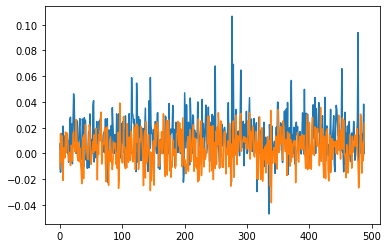

In [11]:
orig = train_loader.dataset.tensors[0].detach().numpy()[0, :]  # Ohne den letzten Eintrag (Label)
gen = generated_np[0, :-1]                                     # Ohne den letzten Eintrag (Label)

plt.plot(orig)    # Die Daten etwas "ran zoomen" nur erste 100 anzeigen
plt.plot(gen)


**Zoom in the first 100 records**

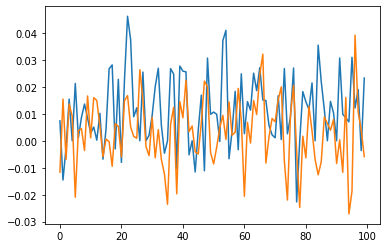

In [12]:
plt.plot(orig[:100])    # Die Daten etwas "ran zoomen" nur erste 100 anzeigen
plt.plot(gen[:100])

# Part II: SP500 Classification with extended data samples

## 6. SP500VAEDataModule

In [13]:
class SP500VAEDataModule(pl.LightningDataModule):
    """Data module for the 'S&P 500' company performance data enhanced with VAE generated training samples."""

    def __init__(self, data, batch_size=32, train_val_test_split=[80,10,10]):
        super().__init__()
        # prepare and transform properties
        self.batch_size = batch_size
        self.train_val_test_split = train_val_test_split
        # data
        self.data = data
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None


    def prepare_data(self):
        """Download and prepare the data."""
        pass

    def setup(self, stage: Optional[str] = None):
        """Setup the data according the stage 'fit' or 'test'. If the stage is none, setup the data for all stages."""

        # Split data into test, val and train dataframes
        train_percent, val_percent, test_percent = self.train_val_test_split
        rows = self.data.shape[0]
        test_rows = int(test_percent * rows / 100)
        val_rows = int(val_percent * rows / 100)
        train_rows =  rows - test_rows - val_rows

        print("Setup - define data split:")
        print("- Train rows : {0:04d} ( {1}%)".format(train_rows, train_percent))
        print("- Val   rows : {0:04d} ( {1}%)".format(val_rows, val_percent))
        print("- Test  rows : {0:04d} ( {1}%)".format(test_rows, test_percent))
        print("- Total rows : {0:04d} (100%)".format(rows))

        print("Setup - split and transform data for stage: {}".format(stage))
        if stage == "fit" or stage is None:
            train_data = self.data.iloc[:train_rows]
            val_data = self.data.iloc[train_rows:train_rows+val_rows]
            print("- Train shape: {}".format(train_data.shape))
            print("- Val   shape: {}".format(val_data.shape))
            # transform data and assign properties to use in data loaders
            self.train_dataset = self._transform_to_dataset(train_data)
            self.val_dataset = self._transform_to_dataset(val_data)

        if stage == "test" or stage is None:
            test_data = self.data.iloc[train_rows+val_rows:]
            print("- Test  shape: {}".format(test_data.shape))
            # transform data and assign properties to use in data loaders
            self.test_dataset = self._transform_to_dataset(test_data)

        print("- Total shape: {}".format(self.data.shape))


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

    def _transform_to_dataset(self, df):

        # Split labels and features
        labels = df.SPY.values
        features = df.iloc[:, :-1].values

        # Convert to tensor
        tensor_labels   = torch.tensor(labels).unsqueeze(1).float()
        tensor_features = torch.tensor(features).float()

        # Create tensor dataset
        return TensorDataset(tensor_features, tensor_labels)

## 7. SP500ClassifierModel

In [14]:
class SP500ClassifierModel(pl.LightningModule):

    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.metric = torchmetrics.Accuracy()
        # Model
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(489, 512),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Loss
        self.loss_fn = F.binary_cross_entropy_with_logits

    def process_step(self, batch, batch_idx):
        x, y = batch
        pred = self.linear_relu_stack(x)
        loss = self.loss_fn(pred, y)

        # calculate accuracy
        pred = (pred>0.5).int()
        acc = self.metric(pred, y.int())

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        print("val_loss:", loss)
        self.log('val_accuracy', acc)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # Update params step: params = params - lr * grad
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## 8. Train SP500ClassifierModel with extended data samples (SP500VAEDataModule)

### Merge Data

**Original data**

In [15]:
original_df = sp500_datamodule.data
original_df

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,SPY
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.007375,-0.014569,-0.002473,0.015445,0.000000,0.021253,0.001145,0.008668,0.013641,0.008393,...,0.012689,0.013980,0.004539,0.000000,0.003426,0.015278,0.011224,0.038231,0.000000,1
2010-01-05,-0.010922,0.107246,-0.005962,0.001727,0.000000,-0.007160,-0.024321,-0.008112,0.006162,0.016313,...,-0.012689,0.003897,-0.011959,0.000000,-0.003426,0.031165,-0.001745,0.034651,0.000000,1
2010-01-06,-0.003559,-0.042314,0.008682,-0.016034,0.000000,-0.009501,-0.015358,0.005539,0.010574,-0.002124,...,-0.006807,0.008606,0.006566,0.000000,-0.007174,-0.000323,-0.007717,0.083382,0.000000,1
2010-01-07,-0.001297,0.029044,-0.000247,-0.001850,0.000000,-0.016166,0.000000,0.008250,-0.000935,-0.019595,...,-0.010095,-0.003147,0.013005,0.000000,-0.000288,0.022681,-0.025318,0.106160,0.000000,1
2010-01-08,-0.000325,-0.019268,0.003945,0.006626,0.000000,0.010807,-0.020446,0.005099,-0.003986,-0.005436,...,0.014505,-0.004020,0.000000,0.000000,0.000288,-0.021228,-0.003256,-0.016320,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,-0.003322,-0.031488,0.010189,-0.019349,0.009812,0.008069,-0.043423,0.010934,-0.007457,-0.031050,...,-0.035299,-0.019897,-0.000718,-0.009331,-0.003095,-0.003803,-0.023644,-0.001229,-0.016667,0
2021-11-11,-0.003081,-0.011189,0.015553,-0.000338,-0.001028,0.000080,0.002864,-0.004469,0.004022,-0.006710,...,0.053570,0.001868,-0.022868,-0.014929,-0.011030,-0.008854,0.005588,0.012523,-0.004118,1
2021-11-12,0.013076,-0.049986,0.002471,0.014235,0.002911,0.000878,0.011987,0.009386,0.013615,0.022188,...,0.023760,-0.007648,0.008410,0.001687,0.006409,-0.002339,0.011522,-0.006242,0.005364,1


**Generated data**

In [16]:
# Rename label column name to 'SPY'
generated_df.rename(columns={489: 'SPY'}, inplace=True)
generated_df

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,SPY
0,-0.011653,0.015470,-0.006914,0.013655,0.009119,-0.020958,0.003790,0.004509,-0.003615,0.016642,...,-0.019169,0.008474,0.030544,0.028342,-0.015323,0.007714,-0.005794,0.000117,0.023572,1.0
1,-0.014290,0.013180,-0.028836,-0.007642,-0.014798,0.008813,0.006815,0.007534,0.014212,-0.013079,...,-0.010721,-0.024389,0.009019,-0.006053,-0.002905,-0.008290,-0.004506,-0.007830,0.002366,1.0
2,0.000285,0.009342,0.001885,-0.011000,0.007022,0.004747,0.003407,0.012922,-0.013720,-0.015277,...,-0.013035,-0.005143,-0.001382,-0.003091,0.019470,0.024643,-0.009110,-0.001161,0.015146,1.0
3,0.010673,-0.016490,-0.007390,0.001602,0.001330,-0.014099,0.019956,-0.018199,-0.008102,-0.020999,...,-0.022641,-0.035414,0.014318,-0.020342,0.018413,0.012526,0.002736,-0.019061,0.003080,1.0
4,-0.003875,0.012943,-0.045891,0.007490,0.010026,0.007371,0.009923,-0.000910,0.023387,-0.003994,...,-0.042004,0.002619,0.020044,0.004483,-0.025828,0.004298,-0.002268,-0.013497,0.014703,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239195,-0.008162,-0.016053,-0.008407,0.002953,0.004560,0.002540,-0.003785,-0.003752,0.006502,0.012908,...,-0.005614,-0.025181,0.009647,0.013938,0.014965,0.005226,0.002332,-0.000529,0.008820,1.0
239196,0.009182,-0.003492,-0.031926,0.002392,-0.018793,-0.023827,-0.001044,0.019828,-0.013035,0.004122,...,-0.016158,-0.003497,0.009215,0.000990,-0.002107,0.026849,-0.009697,-0.010849,0.010476,1.0
239197,-0.001418,-0.018311,0.011483,0.023322,0.025636,-0.023102,0.001740,0.012530,0.048115,0.026004,...,-0.001022,-0.014729,-0.008987,-0.006958,0.006516,-0.007015,0.000834,0.006865,-0.025998,1.0
239198,0.011325,-0.020572,0.004177,0.006183,-0.016365,-0.008930,-0.001547,0.006603,-0.020364,0.001661,...,-0.005893,0.003972,0.011390,0.008293,0.009735,0.005635,-0.006039,-0.011798,0.021181,1.0


**Merged data**

In [17]:
original_df.columns = generated_df.columns
merged_df = generated_df.append(original_df, ignore_index=True)

merged_df = merged_df.reset_index()
del merged_df['index']

merged_df

,0,1,2,3,4,5,6,7,8,9,...,480,481,482,483,484,485,486,487,488,SPY
0,-0.011653,0.015470,-0.006914,0.013655,0.009119,-0.020958,0.003790,0.004509,-0.003615,0.016642,...,-0.019169,0.008474,0.030544,0.028342,-0.015323,0.007714,-0.005794,0.000117,0.023572,1.0
1,-0.014290,0.013180,-0.028836,-0.007642,-0.014798,0.008813,0.006815,0.007534,0.014212,-0.013079,...,-0.010721,-0.024389,0.009019,-0.006053,-0.002905,-0.008290,-0.004506,-0.007830,0.002366,1.0
2,0.000285,0.009342,0.001885,-0.011000,0.007022,0.004747,0.003407,0.012922,-0.013720,-0.015277,...,-0.013035,-0.005143,-0.001382,-0.003091,0.019470,0.024643,-0.009110,-0.001161,0.015146,1.0
3,0.010673,-0.016490,-0.007390,0.001602,0.001330,-0.014099,0.019956,-0.018199,-0.008102,-0.020999,...,-0.022641,-0.035414,0.014318,-0.020342,0.018413,0.012526,0.002736,-0.019061,0.003080,1.0
4,-0.003875,0.012943,-0.045891,0.007490,0.010026,0.007371,0.009923,-0.000910,0.023387,-0.003994,...,-0.042004,0.002619,0.020044,0.004483,-0.025828,0.004298,-0.002268,-0.013497,0.014703,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242185,-0.003322,-0.031488,0.010189,-0.019349,0.009812,0.008069,-0.043423,0.010934,-0.007457,-0.031050,...,-0.035299,-0.019897,-0.000718,-0.009331,-0.003095,-0.003803,-0.023644,-0.001229,-0.016667,0.0
242186,-0.003081,-0.011189,0.015553,-0.000338,-0.001028,0.000080,0.002864,-0.004469,0.004022,-0.006710,...,0.053570,0.001868,-0.022868,-0.014929,-0.011030,-0.008854,0.005588,0.012523,-0.004118,1.0
242187,0.013076,-0.049986,0.002471,0.014235,0.002911,0.000878,0.011987,0.009386,0.013615,0.022188,...,0.023760,-0.007648,0.008410,0.001687,0.006409,-0.002339,0.011522,-0.006242,0.005364,1.0
242188,-0.019457,0.001477,0.011935,0.000067,-0.001112,-0.007367,-0.035337,0.007678,-0.007517,0.003234,...,0.006852,0.008581,0.000546,-0.008154,0.010881,-0.009487,-0.001827,0.013199,-0.003650,1.0


### Train model

In [18]:
epochs = 12
batch_size = 2048
learning_rate = 0.0001

train_val_test_split=[90,10,0]
gpus = 1 if torch.cuda.is_available() else 0
progress_bar_refresh_rate=96

sp500_vae_datamodule = SP500VAEDataModule(merged_df, batch_size=batch_size, train_val_test_split=train_val_test_split)
model = SP500ClassifierModel(learning_rate=learning_rate)

trainer = pl.Trainer(gpus=gpus, max_epochs=epochs, progress_bar_refresh_rate=progress_bar_refresh_rate)

trainer.fit(model, sp500_vae_datamodule)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setup - define data split:
- Train rows : 217971 ( 90%)
- Val   rows : 24219 ( 10%)
- Test  rows : 0000 ( 0%)
- Total rows : 242190 (100%)
Setup - split and transform data for stage: fit
- Train shape: (217971, 490)
- Val   shape: (24219, 490)
- Total shape: (242190, 490)



  | Name              | Type       | Params
-------------------------------------------------
0 | metric            | Accuracy   | 0     
1 | linear_relu_stack | Sequential | 285 K 
-------------------------------------------------
285 K     Trainable params
0         Non-trainable params
285 K     Total params
1.143     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

val_loss: tensor(0.7020)
val_loss: tensor(0.7023)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6921)
val_loss: tensor(0.6921)
val_loss: tensor(0.6921)
val_loss: tensor(0.6919)
val_loss: tensor(0.6921)
val_loss: tensor(0.6922)
val_loss: tensor(0.6921)
val_loss: tensor(0.6921)
val_loss: tensor(0.6919)
val_loss: tensor(0.6920)
val_loss: tensor(0.6888)
val_loss: tensor(0.6872)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6883)
val_loss: tensor(0.6880)
val_loss: tensor(0.6880)
val_loss: tensor(0.6868)
val_loss: tensor(0.6880)
val_loss: tensor(0.6886)
val_loss: tensor(0.6875)
val_loss: tensor(0.6883)
val_loss: tensor(0.6875)
val_loss: tensor(0.6877)
val_loss: tensor(0.6787)
val_loss: tensor(0.6753)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6879)
val_loss: tensor(0.6878)
val_loss: tensor(0.6866)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6873)
val_loss: tensor(0.6882)
val_loss: tensor(0.6874)
val_loss: tensor(0.6876)
val_loss: tensor(0.6789)
val_loss: tensor(0.6757)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6879)
val_loss: tensor(0.6878)
val_loss: tensor(0.6866)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6872)
val_loss: tensor(0.6882)
val_loss: tensor(0.6874)
val_loss: tensor(0.6876)
val_loss: tensor(0.6797)
val_loss: tensor(0.6770)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6878)
val_loss: tensor(0.6877)
val_loss: tensor(0.6865)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6871)
val_loss: tensor(0.6882)
val_loss: tensor(0.6874)
val_loss: tensor(0.6875)
val_loss: tensor(0.6801)
val_loss: tensor(0.6778)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6878)
val_loss: tensor(0.6877)
val_loss: tensor(0.6865)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6870)
val_loss: tensor(0.6882)
val_loss: tensor(0.6874)
val_loss: tensor(0.6875)
val_loss: tensor(0.6805)
val_loss: tensor(0.6785)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6878)
val_loss: tensor(0.6876)
val_loss: tensor(0.6864)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6869)
val_loss: tensor(0.6882)
val_loss: tensor(0.6874)
val_loss: tensor(0.6874)
val_loss: tensor(0.6806)
val_loss: tensor(0.6790)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6878)
val_loss: tensor(0.6876)
val_loss: tensor(0.6865)
val_loss: tensor(0.6879)
val_loss: tensor(0.6885)
val_loss: tensor(0.6869)
val_loss: tensor(0.6883)
val_loss: tensor(0.6874)
val_loss: tensor(0.6875)
val_loss: tensor(0.6812)
val_loss: tensor(0.6799)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6883)
val_loss: tensor(0.6879)
val_loss: tensor(0.6875)
val_loss: tensor(0.6865)
val_loss: tensor(0.6879)
val_loss: tensor(0.6886)
val_loss: tensor(0.6869)
val_loss: tensor(0.6883)
val_loss: tensor(0.6875)
val_loss: tensor(0.6875)
val_loss: tensor(0.6817)
val_loss: tensor(0.6808)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6882)
val_loss: tensor(0.6879)
val_loss: tensor(0.6875)
val_loss: tensor(0.6865)
val_loss: tensor(0.6879)
val_loss: tensor(0.6886)
val_loss: tensor(0.6868)
val_loss: tensor(0.6883)
val_loss: tensor(0.6875)
val_loss: tensor(0.6875)
val_loss: tensor(0.6819)
val_loss: tensor(0.6812)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6883)
val_loss: tensor(0.6879)
val_loss: tensor(0.6875)
val_loss: tensor(0.6865)
val_loss: tensor(0.6880)
val_loss: tensor(0.6886)
val_loss: tensor(0.6868)
val_loss: tensor(0.6883)
val_loss: tensor(0.6875)
val_loss: tensor(0.6874)
val_loss: tensor(0.6821)
val_loss: tensor(0.6816)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6883)
val_loss: tensor(0.6879)
val_loss: tensor(0.6874)
val_loss: tensor(0.6865)
val_loss: tensor(0.6880)
val_loss: tensor(0.6886)
val_loss: tensor(0.6867)
val_loss: tensor(0.6884)
val_loss: tensor(0.6875)
val_loss: tensor(0.6875)
val_loss: tensor(0.6821)
val_loss: tensor(0.6818)


## 9. Test SP500ClassifierModel with original data (SP500DataModule)
For the test we use the **original S&P Data**.

In [19]:
trainer.test(datamodule=sp500_datamodule)


Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\05_vae\lightning_logs\version_0\checkpoints\epoch=11-step=1283.ckpt
Loaded model weights from checkpoint at D:\dev\workspace\surfmachine\ai\src\05_vae\lightning_logs\version_0\checkpoints\epoch=11-step=1283.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.4214046895503998, 'test_loss': 0.6780058145523071}
--------------------------------------------------------------------------------


[{'test_loss': 0.6780058145523071, 'test_accuracy': 0.4214046895503998}]

# Part III: SP500 Classification with augmented model

## 10. SP500VAEClassifierModel

In [20]:
class SP500VAEClassifierModel(pl.LightningModule):

    def __init__(self, vae_model, learning_rate=0.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.metric = torchmetrics.Accuracy()
        # Model
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(489, 512),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        # Loss
        self.loss_fn = F.binary_cross_entropy_with_logits
        # VAE model
        self.vae_model = vae_model


    def process_step(self, batch, batch_idx, augmented=False, augmented_step=4):
        x, y = batch
        # calcultae pred (y-hat)
        if augmented:
            if batch_idx%augmented_step == 0:
                x_augmented, _, _ = self.vae_model(x)
                pred = self.linear_relu_stack(x_augmented)
            else:
                pred = self.linear_relu_stack(x)
        else:
            pred = self.linear_relu_stack(x)
        # calculate loss
        loss = self.loss_fn(pred, y)
        # calculate accuracy
        pred = (pred>0.5).int()
        acc = self.metric(pred, y.int())

        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx, augmented=True)
        self.log('train_loss', loss)
        self.log('train_accuracy', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        print("val_loss:", loss)
        self.log('val_accuracy', acc)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss, acc = self.process_step(batch, batch_idx)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # Update params step: params = params - lr * grad
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## 11. Train SP500VAEClassifierModel with original data (SP500DataModule)

In [21]:
epochs = 30
batch_size = 48
learning_rate = 0.0001

train_val_test_split=[80,10,10]
gpus = 1 if torch.cuda.is_available() else 0
progress_bar_refresh_rate=16

sp500_datamodule = SP500DataModule(batch_size=batch_size, train_val_test_split=train_val_test_split)
model = SP500VAEClassifierModel(vae_model, learning_rate=learning_rate)

trainer = pl.Trainer(gpus=gpus, max_epochs=epochs, progress_bar_refresh_rate=progress_bar_refresh_rate)

trainer.fit(model, sp500_datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Load SP500 from file: ./sp500.csv



  | Name              | Type       | Params
-------------------------------------------------
0 | metric            | Accuracy   | 0     
1 | linear_relu_stack | Sequential | 285 K 
2 | vae_model         | VAE        | 416 K 
-------------------------------------------------
702 K     Trainable params
0         Non-trainable params
702 K     Total params
2.809     Total estimated model params size (MB)


Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: fit
- Train shape: (2392, 490)
- Val   shape: (299, 490)
- Total shape: (2990, 490)


Validation sanity check: 0it [00:00, ?it/s]

val_loss: tensor(0.6982)
val_loss: tensor(0.6982)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6933)
val_loss: tensor(0.6948)
val_loss: tensor(0.6995)
val_loss: tensor(0.6836)
val_loss: tensor(0.6931)
val_loss: tensor(0.7021)
val_loss: tensor(0.6911)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6872)
val_loss: tensor(0.6903)
val_loss: tensor(0.6938)
val_loss: tensor(0.6717)
val_loss: tensor(0.6848)
val_loss: tensor(0.6956)
val_loss: tensor(0.6840)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6753)
val_loss: tensor(0.6819)
val_loss: tensor(0.6842)
val_loss: tensor(0.6389)
val_loss: tensor(0.6640)
val_loss: tensor(0.6837)
val_loss: tensor(0.6696)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6551)
val_loss: tensor(0.6686)
val_loss: tensor(0.6700)
val_loss: tensor(0.5782)
val_loss: tensor(0.6305)
val_loss: tensor(0.6672)
val_loss: tensor(0.6419)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.6109)
val_loss: tensor(0.6403)
val_loss: tensor(0.6410)
val_loss: tensor(0.4657)
val_loss: tensor(0.5619)
val_loss: tensor(0.6348)
val_loss: tensor(0.5806)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.5427)
val_loss: tensor(0.5939)
val_loss: tensor(0.5921)
val_loss: tensor(0.3432)
val_loss: tensor(0.4705)
val_loss: tensor(0.5855)
val_loss: tensor(0.4933)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.4593)
val_loss: tensor(0.5315)
val_loss: tensor(0.5220)
val_loss: tensor(0.2364)
val_loss: tensor(0.3749)
val_loss: tensor(0.5191)
val_loss: tensor(0.3970)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.3851)
val_loss: tensor(0.4739)
val_loss: tensor(0.4510)
val_loss: tensor(0.1681)
val_loss: tensor(0.3127)
val_loss: tensor(0.4586)
val_loss: tensor(0.3170)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.3209)
val_loss: tensor(0.4206)
val_loss: tensor(0.3805)
val_loss: tensor(0.1205)
val_loss: tensor(0.2803)
val_loss: tensor(0.4061)
val_loss: tensor(0.2496)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2778)
val_loss: tensor(0.3816)
val_loss: tensor(0.3262)
val_loss: tensor(0.0913)
val_loss: tensor(0.2772)
val_loss: tensor(0.3764)
val_loss: tensor(0.2062)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2485)
val_loss: tensor(0.3543)
val_loss: tensor(0.2821)
val_loss: tensor(0.0713)
val_loss: tensor(0.2903)
val_loss: tensor(0.3597)
val_loss: tensor(0.1773)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2338)
val_loss: tensor(0.3388)
val_loss: tensor(0.2552)
val_loss: tensor(0.0598)
val_loss: tensor(0.3079)
val_loss: tensor(0.3568)
val_loss: tensor(0.1644)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2244)
val_loss: tensor(0.3301)
val_loss: tensor(0.2351)
val_loss: tensor(0.0510)
val_loss: tensor(0.3297)
val_loss: tensor(0.3637)
val_loss: tensor(0.1583)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2190)
val_loss: tensor(0.3239)
val_loss: tensor(0.2197)
val_loss: tensor(0.0443)
val_loss: tensor(0.3500)
val_loss: tensor(0.3709)
val_loss: tensor(0.1530)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2158)
val_loss: tensor(0.3196)
val_loss: tensor(0.2114)
val_loss: tensor(0.0400)
val_loss: tensor(0.3622)
val_loss: tensor(0.3800)
val_loss: tensor(0.1522)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2138)
val_loss: tensor(0.3172)
val_loss: tensor(0.2045)
val_loss: tensor(0.0368)
val_loss: tensor(0.3666)
val_loss: tensor(0.3795)
val_loss: tensor(0.1469)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2122)
val_loss: tensor(0.3146)
val_loss: tensor(0.2011)
val_loss: tensor(0.0342)
val_loss: tensor(0.3745)
val_loss: tensor(0.3905)
val_loss: tensor(0.1496)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2111)
val_loss: tensor(0.3133)
val_loss: tensor(0.1968)
val_loss: tensor(0.0316)
val_loss: tensor(0.3822)
val_loss: tensor(0.3970)
val_loss: tensor(0.1496)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2103)
val_loss: tensor(0.3115)
val_loss: tensor(0.1908)
val_loss: tensor(0.0292)
val_loss: tensor(0.3859)
val_loss: tensor(0.3953)
val_loss: tensor(0.1422)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2087)
val_loss: tensor(0.3092)
val_loss: tensor(0.1881)
val_loss: tensor(0.0275)
val_loss: tensor(0.3877)
val_loss: tensor(0.4001)
val_loss: tensor(0.1419)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2078)
val_loss: tensor(0.3085)
val_loss: tensor(0.1854)
val_loss: tensor(0.0256)
val_loss: tensor(0.3928)
val_loss: tensor(0.4074)
val_loss: tensor(0.1410)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2082)
val_loss: tensor(0.3092)
val_loss: tensor(0.1794)
val_loss: tensor(0.0237)
val_loss: tensor(0.3965)
val_loss: tensor(0.4038)
val_loss: tensor(0.1327)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2059)
val_loss: tensor(0.3072)
val_loss: tensor(0.1787)
val_loss: tensor(0.0225)
val_loss: tensor(0.3977)
val_loss: tensor(0.4132)
val_loss: tensor(0.1337)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2035)
val_loss: tensor(0.3041)
val_loss: tensor(0.1776)
val_loss: tensor(0.0213)
val_loss: tensor(0.3962)
val_loss: tensor(0.4196)
val_loss: tensor(0.1330)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2022)
val_loss: tensor(0.3024)
val_loss: tensor(0.1738)
val_loss: tensor(0.0199)
val_loss: tensor(0.3967)
val_loss: tensor(0.4205)
val_loss: tensor(0.1273)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2008)
val_loss: tensor(0.3006)
val_loss: tensor(0.1749)
val_loss: tensor(0.0191)
val_loss: tensor(0.3967)
val_loss: tensor(0.4296)
val_loss: tensor(0.1279)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2028)
val_loss: tensor(0.3012)
val_loss: tensor(0.1680)
val_loss: tensor(0.0174)
val_loss: tensor(0.4036)
val_loss: tensor(0.4252)
val_loss: tensor(0.1178)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2010)
val_loss: tensor(0.2991)
val_loss: tensor(0.1658)
val_loss: tensor(0.0166)
val_loss: tensor(0.3985)
val_loss: tensor(0.4234)
val_loss: tensor(0.1150)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.2005)
val_loss: tensor(0.2988)
val_loss: tensor(0.1634)
val_loss: tensor(0.0156)
val_loss: tensor(0.3994)
val_loss: tensor(0.4265)
val_loss: tensor(0.1133)


Validating: 0it [00:00, ?it/s]

val_loss: tensor(0.1984)
val_loss: tensor(0.2976)
val_loss: tensor(0.1643)
val_loss: tensor(0.0149)
val_loss: tensor(0.3996)
val_loss: tensor(0.4390)
val_loss: tensor(0.1165)


## 12. Test SP500VAEClassifierModel with original data (SP500DataModule)

In [22]:
trainer.test(datamodule=sp500_datamodule)

Restoring states from the checkpoint path at D:\dev\workspace\surfmachine\ai\src\05_vae\lightning_logs\version_1\checkpoints\epoch=29-step=1499.ckpt
Loaded model weights from checkpoint at D:\dev\workspace\surfmachine\ai\src\05_vae\lightning_logs\version_1\checkpoints\epoch=29-step=1499.ckpt


Setup - define data split:
- Train rows : 2392 ( 80%)
- Val   rows : 0299 ( 10%)
- Test  rows : 0299 ( 10%)
- Total rows : 2990 (100%)
Setup - split and transform data for stage: test
- Test  shape: (299, 490)
- Total shape: (2990, 490)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.8528428077697754, 'test_loss': 0.3943193554878235}
--------------------------------------------------------------------------------


[{'test_loss': 0.3943193554878235, 'test_accuracy': 0.8528428077697754}]

## 13. Visualize with Tensorboard

Run the following commands in a terminal:<br />
1. Change to folder with notebook
2. Run command: tensorboard --logdir=./lightning_logs

In [23]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

Launching TensorBoard...

---
The end.